# **Projet : Prévision de consommation d'éléctricité**

Partie 3 : Application des modèles de prévision



1.   Holt-Winters
2.   SARIMA
3.   SARIMAX


<h2>Rappel des modèles utilisés</h2>

<h3>1. Holt-Winters additif</h3>
<p><strong>Composantes :</strong> niveau (L<sub>t</sub>), tendance (T<sub>t</sub>), saisonnalité (S<sub>t</sub>)</p>
<p><strong>Formules :</strong></p>
<ul>
  <li>L<sub>t</sub> = α (Y<sub>t</sub> - S<sub>t-m</sub>) + (1-α)(L<sub>t-1</sub> + T<sub>t-1</sub>)</li>
  <li>T<sub>t</sub> = β (L<sub>t</sub> - L<sub>t-1</sub>) + (1-β) T<sub>t-1</sub></li>
  <li>S<sub>t</sub> = γ (Y<sub>t</sub> - L<sub>t</sub>) + (1-γ) S<sub>t-m</sub></li>
  <li>Ŷ<sub>t+h</sub> = L<sub>t</sub> + h T<sub>t</sub> + S<sub>t-m+h<sub>m</sub></sub>, où h<sub>m</sub> = ((h-1) mod m) + 1</li>
</ul>
<p><strong>Paramètres :</strong></p>
<ul>
  <li>Y<sub>t</sub> : observation réelle à l’instant t</li>
  <li>m : période saisonnière</li>
  <li>α, β, γ : coefficients de lissage (niveau, tendance, saisonnalité)</li>
</ul>

<h3>2. SARIMA (Seasonal ARIMA)</h3>
<p><strong>Notation :</strong> SARIMA(p,d,q) × (P,D,Q)<sub>m</sub></p>
<p><strong>Formule générale :</strong></p>
<p>Φ<sub>P</sub>(B<sup>m</sup>) φ<sub>p</sub>(B) ∇<sup>d</sup> ∇<sup>D</sup><sub>m</sub> Y<sub>t</sub> = Θ<sub>Q</sub>(B<sup>m</sup>) θ<sub>q</sub>(B) ε<sub>t</sub></p>
<ul>
  <li>B : opérateur retard (B Y<sub>t</sub> = Y<sub>t-1</sub>)</li>
  <li>φ<sub>p</sub>(B), θ<sub>q</sub>(B) : polynômes AR et MA</li>
  <li>Φ<sub>P</sub>(B<sup>m</sup>), Θ<sub>Q</sub>(B<sup>m</sup>) : polynômes saisonniers AR et MA</li>
  <li>∇<sup>d</sup> = (1-B)<sup>d</sup> : différenciation non saisonnière</li>
  <li>∇<sup>D</sup><sub>m</sub> = (1-B<sup>m</sup>)<sup>D</sup> : différenciation saisonnière</li>
  <li>ε<sub>t</sub> : terme d’erreur blanc</li>
</ul>

<h3>3. SARIMAX (SARIMA avec variables exogènes)</h3>
<p><strong>Formule :</strong></p>
<p>Y<sub>t</sub> = SARIMA(p,d,q)(P,D,Q)<sub>m</sub> + X<sub>t</sub> β + ε<sub>t</sub></p>
<ul>
  <li>X<sub>t</sub> : vecteur des variables exogènes (ex. température, DJU)</li>
  <li>β : coefficients associés aux variables exogènes</li>
  <li>Le reste est identique à SARIMA pour la composante temporelle</li>
</ul>

 


In [73]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import statsmodels.api as sm




# Étapes pour appliquer le modèle Holt-Winters additif

1. **Importer et visualiser la série temporelle**  
   - Charger les données et tracer la série pour observer tendances et saisonnalités.

2. **(Optionnel mais recommandé) Décomposer la série**  
   - Identifier les composantes : tendance, saisonnalité, résidus.  
   - Vérifier si la saisonnalité est constante (adapté au modèle additif).

3. **Ajuster le modèle Holt-Winters additif**  
   - Définir `trend="add"`, `seasonal="add"`, et `seasonal_periods`.

4. **Vérifier l’ajustement du modèle**  
   - Comparer la courbe réelle avec la courbe prédite.

5. **Prévoir le futur (forecast)**  
   - Générer les prévisions pour les pas de temps souhaités.

6. **Évaluer les performances du modèle**  
   - Calculer des métriques comme MAE, RMSE, AIC.

7. **Analyser les résidus**  
   - Vérifier l’absence de tendance, d’autocorrélation et de motifs saisonniers non capturés.


In [33]:
df = pd.read_csv('df_corrigé.csv')
df

,Mois,Consommation totale,dju_chauffage,conso_corr
0,2012-01-01,51086,336.0,43259.231509
1,2012-02-01,54476,435.9,41804.889062
2,2012-03-01,43156,201.9,41831.997497
3,2012-04-01,40176,230.3,37474.827072
4,2012-05-01,35257,83.3,39684.138781
...,...,...,...,...
79,2018-08-01,32451,3.3,40757.492092
80,2018-09-01,32683,34.3,39486.242684
81,2018-10-01,37102,122.4,39633.104850
82,2018-11-01,43738,282.5,38505.549036


In [34]:
df.set_index('Mois' , inplace = True)

df.index = pd.to_datetime(df.index)

In [35]:
df=df.drop(columns='Consommation totale')
df

,dju_chauffage,conso_corr
Mois,,
2012-01-01,336.0,43259.231509
2012-02-01,435.9,41804.889062
2012-03-01,201.9,41831.997497
2012-04-01,230.3,37474.827072
2012-05-01,83.3,39684.138781
...,...,...
2018-08-01,3.3,40757.492092
2018-09-01,34.3,39486.242684
2018-10-01,122.4,39633.104850


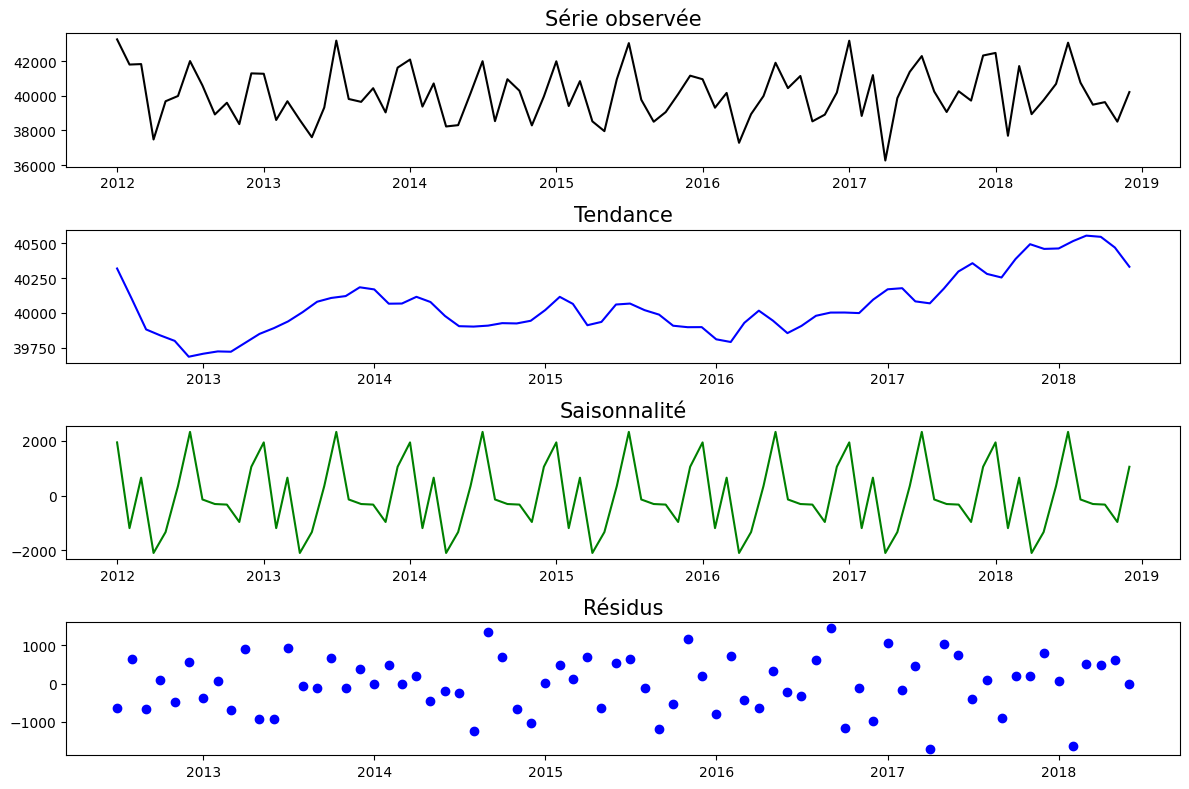

In [36]:
#1.	Décomposer la série : en tandance ,saisonalité et résidue



decomposition = seasonal_decompose(df['conso_corr'], model='additive')

# Création de la figure
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

ax[0].plot(decomposition.observed, color='black')
ax[0].set_title('Série observée', fontsize=15)

ax[1].plot(decomposition.trend, color='blue')
ax[1].set_title('Tendance', fontsize=15)

ax[2].plot(decomposition.seasonal, color='green')
ax[2].set_title('Saisonnalité', fontsize=15)

ax[3].plot(decomposition.resid, 'bo')
ax[3].set_title('Résidus', fontsize=15)

plt.tight_layout()

plt.show()

In [37]:
y = df['conso_corr']
train_size = len(y) - 12
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train size:", len(y_train), "Test size:", len(y_test))

Train size: 72 Test size: 12


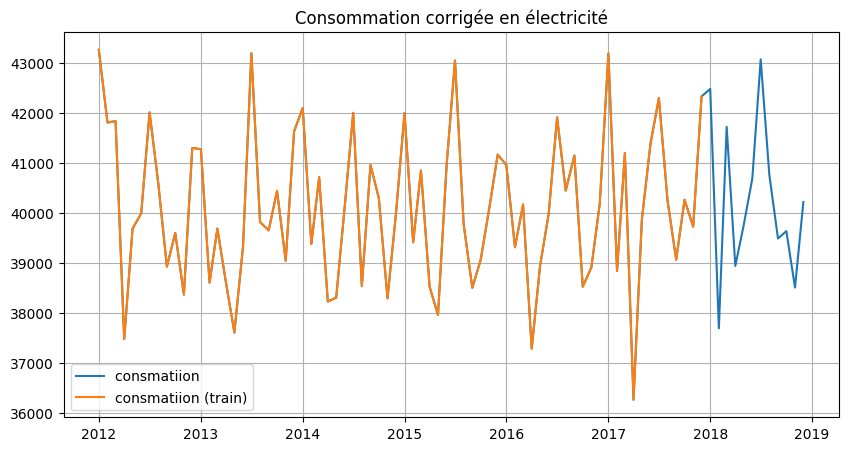

In [38]:
plt.figure(figsize=(10,5))
y=df["conso_corr"]
plt.plot(y, label="consmatiion ")
plt.plot(y_train, label="consmatiion (train)")
plt.title("Consommation corrigée en électricité")
plt.legend()
plt.grid(True)
plt.show()

In [39]:

model_hw=ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
)

fit_hw = model_hw.fit(optimized=True)
print(fit_hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               conso_corr   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                       45179854.675
Optimized:                         True   AIC                            993.164
Trend:                         Additive   BIC                           1029.590
Seasonal:                      Additive   AICC                          1006.069
Seasonal Periods:                    12   Date:                 Tue, 16 Sep 2025
Box-Cox:                          False   Time:                         16:20:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


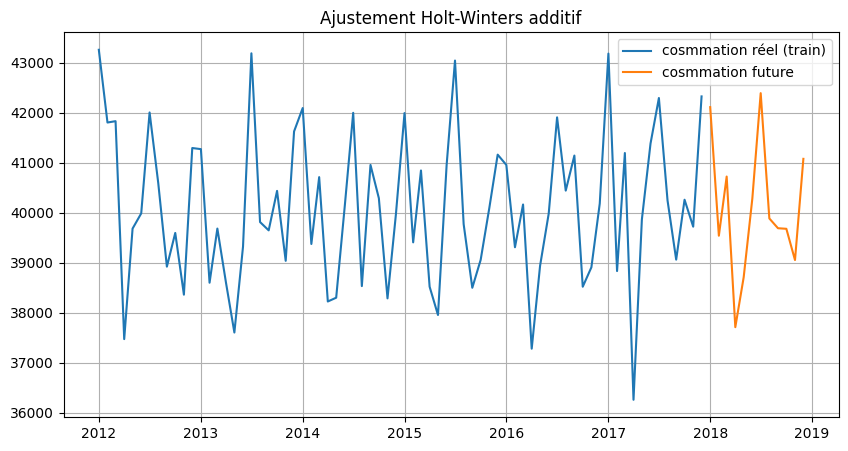

In [40]:
#Prévisions futures
# Prévoir les 12 prochains mois
y_pred_hw = fit_hw.forecast(len(y_test))

plt.figure(figsize=(10,5))
plt.plot(y_train , label="cosmmation réel (train)")
plt.plot(y_pred_hw, label="cosmmation future")
plt.title("Ajustement Holt-Winters additif")
plt.legend()
plt.grid(True)
plt.show()

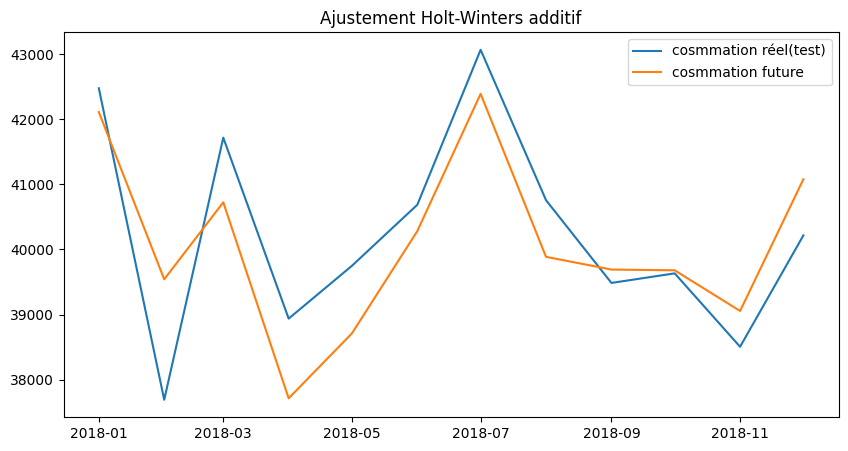

In [41]:
# évaluation de modéle
y_pred_hw = fit_hw.forecast(len(y_test))

plt.figure(figsize=(10,5))
plt.plot(y_test , label="cosmmation réel(test)")
plt.plot(y_pred_hw, label="cosmmation future")
plt.title("Ajustement Holt-Winters additif")
plt.legend()
plt.show()

In [42]:


# MAE et RMSE
mae = mean_absolute_error(y_test, y_pred_hw)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_hw))
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# R2
r2 = r2_score(y_test, y_pred_hw)
print(f"R² : {r2:.3f}")

# AIC (depuis le modèle ajusté)
# Supposons que hw_fit est le modèle Holt-Winters ajusté avec .fit()
aic = fit_hw.aic
print(f"AIC : {aic:.2f}")


MAE : 757.39
RMSE : 894.15
R² : 0.658
AIC : 993.16


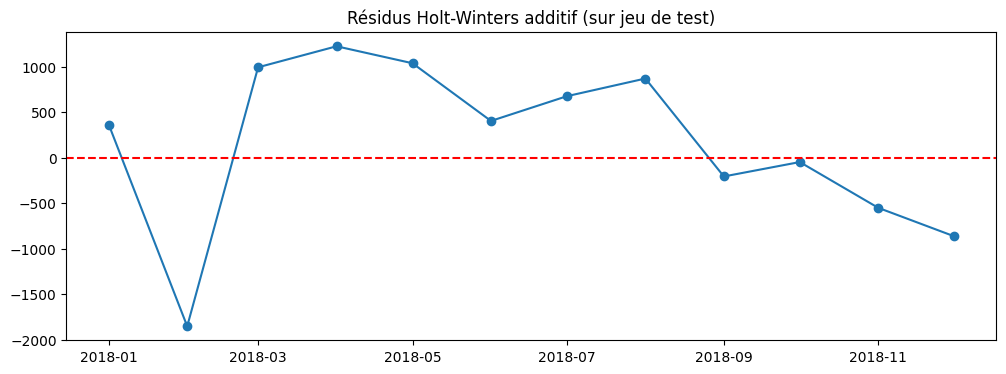

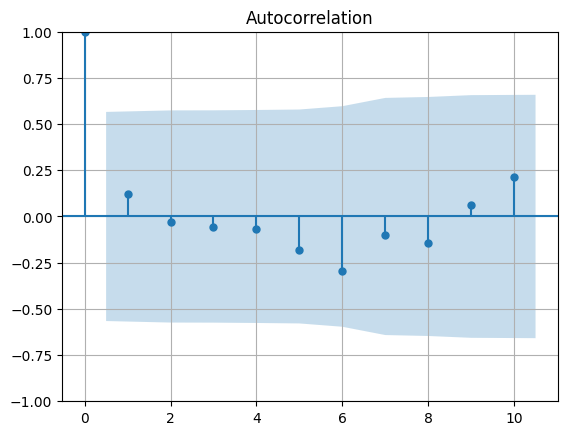

In [43]:
# analyse de résidue


# Résidus uniquement sur la période test
residuals = y_test - y_pred_hw

# Tracé des résidus
plt.figure(figsize=(12,4))
plt.plot(residuals, marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.title("Résidus Holt-Winters additif (sur jeu de test)")
plt.show()

# ACF des résidus
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=10)
plt.grid(True)
plt.show()

Commentaire :

# Prévision à l'aide d'un modèle ARIMA saisonnier : SARIMA(p,d,q)(P,D,Q)_s

## Étapes clés

1. **Identifier la saisonnalité**
   - Analyser les autocorrélogrammes (ACF, PACF) pour détecter la période saisonnière `s`.
   - Observer les motifs récurrents et déterminer la longueur de la saison (ex. 12 pour une saison mensuelle).

2. **Stationnariser la série temporelle**
   - Vérifier si la série présente une tendance ou une saisonnalité.
   - Appliquer la **différenciation non saisonnière** (`d`) pour supprimer la tendance.
   - Appliquer la **différenciation saisonnière** (`D`) pour supprimer la saisonnalité.

3. **Identifier les ordres plausibles**
   - Examiner les autocorrélogrammes et partial autocorrélogrammes pour choisir des valeurs initiales :
     - `p, q` : composantes non saisonnières AR et MA
     - `P, Q` : composantes saisonnières AR et MA
   - La saisonnalité `s` doit être précisée.

4. **Estimer les paramètres du modèle**
   - Ajuster plusieurs modèles SARIMA avec différentes combinaisons d’ordres plausibles.
   - Comparer les modèles à l’aide de critères comme **AIC** ou **BIC** pour choisir le modèle optimal.

5. **Valider le modèle**
   - Examiner les **résidus** : ils doivent être aléatoires, sans tendance ni autocorrélation.
   - Utiliser des tests statistiques (ex. test de Ljung-Box) et visualiser les résidus (ACF, histogramme, Q-Q plot).

6. **Prévisions et évaluation**
   - Générer les prévisions à court et moyen terme.
   - Comparer les prévisions avec les données réelles et calculer des métriques de performance (MAE, RMSE, R²).
   - Ajuster les paramètres si nécessaire et répéter le processus.

7. **Documentation et interprétation**
   - Interpréter la signification des composantes saisonnières et non saisonnières.
   - Vérifier que le modèle capture bien la saisonnalité et les tendances observées dans la série.


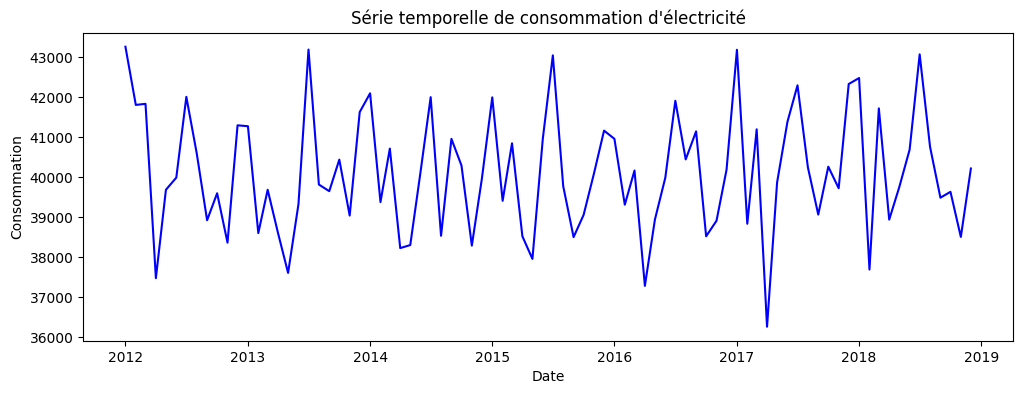

<Figure size 1200x400 with 0 Axes>

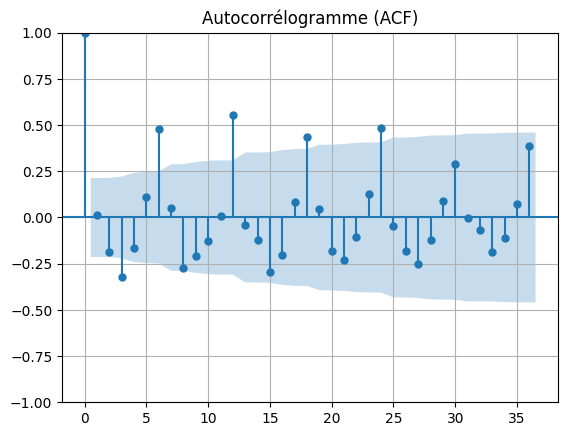

<Figure size 1200x400 with 0 Axes>

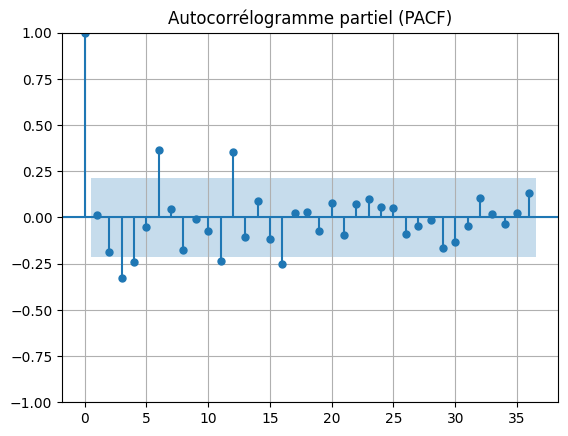

In [44]:

# Visualiser la série temporelle
plt.figure(figsize=(12, 4))
plt.plot(df['conso_corr'], color='blue')
plt.title("Série temporelle de consommation d'électricité")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.show()

# Tracer l'ACF (autocorrélation)
plt.figure(figsize=(12, 4))
plot_acf(df['conso_corr'], lags=36)  # lags = nombre de points de retard à afficher
plt.title("Autocorrélogramme (ACF)")
plt.grid()
plt.show()

# Tracer le PACF (autocorrélation partielle)
plt.figure(figsize=(12, 4))
plot_pacf(df['conso_corr'], lags=36, method='ywm')  # méthode 'ywm' pour stabilité
plt.title("Autocorrélogramme partiel (PACF)")
plt.grid()
plt.show()


Hypothèses du test ADF :

H0: La série n’est pas stationnaire (présence de racine unitaire)

H1: La série est stationnaire

In [45]:
#Stationnarité

from statsmodels.tsa.stattools import adfuller

result=adfuller(df["conso_corr"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

data_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
data_diff1 = data_diff1[1:]  # supprimer le NaN initial

ADF Statistic: -2.181239
p-value: 0.213125


In [46]:
result=adfuller(data_diff1)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -5.084842
p-value: 0.000015


In [47]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series):
    adf_p, kpss_p = None, None
    try:
        adf_p = adfuller(series)[1]
    except:
        adf_p = float('nan')
    try:
        kpss_p = kpss(series, regression='c', nlags="auto")[1]
    except:
        kpss_p = float('nan')
    return adf_p, kpss_p

series = df['conso_corr']
max_diff = 3  # tester jusqu'à 3 différenciations

for d in range(max_diff+1):
    diff_series = series.diff(d).dropna()
    if diff_series.nunique() <= 1:
        print(f"d={d} --> Série constante après différenciation, tests ignorés")
        continue
    adf_p, kpss_p = test_stationarity(diff_series)
    print(f"d={d} --> ADF p-value: {adf_p:.4f}, KPSS p-value: {kpss_p:.4f}")

d=0 --> Série constante après différenciation, tests ignorés
d=1 --> ADF p-value: 0.0000, KPSS p-value: 0.1000
d=2 --> ADF p-value: 0.0000, KPSS p-value: 0.1000
d=3 --> ADF p-value: 0.0250, KPSS p-value: 0.1000


/tmp/ipython-input-443479334.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series, regression='c', nlags="auto")[1]
/tmp/ipython-input-443479334.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series, regression='c', nlags="auto")[1]
/tmp/ipython-input-443479334.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series, regression='c', nlags="auto")[1]


In [48]:
data_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
data_diff1 = data_diff1[1:]  # supprimer le NaN initial

In [49]:


# Fonction pour calculer MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Éviter division par zéro
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Fonction pour rechercher le meilleur SARIMA
def sarima_grid_search(y,
                       p_values, d_values, q_values,
                       P_values, D_values, Q_values, s):
    results_list = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(y,
                                                order=(p,d,q),
                                                seasonal_order=(P,D,Q,s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                res = model.fit(disp=False)

                                pred = res.fittedvalues

                                mse = mean_squared_error(y, pred)
                                rmse = np.sqrt(mse)
                                mae = mean_absolute_error(y, pred)
                                mape = mean_absolute_percentage_error(y, pred)
                                aic = res.aic

                                results_list.append({
                                    'p': p, 'd': d, 'q': q,
                                    'P': P, 'D': D, 'Q': Q,
                                    's': s,
                                    'AIC': aic,
                                    'MSE': mse,
                                    'RMSE': rmse,
                                    'MAE': mae,
                                    'MAPE': mape
                                })
                            except Exception as e:
                                # Afficher l'erreur si nécessaire
                                # print(f"Erreur pour {(p,d,q,P,D,Q,s)}: {e}")
                                continue

    results_df = pd.DataFrame(results_list)
    if not results_df.empty:
        best_model = results_df.sort_values('AIC').iloc[0]
        print("Meilleur modèle selon AIC :")
        print(best_model)
    else:
        print("Aucun modèle valide trouvé.")

    return results_df

# Exemple d'utilisation
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1,2]
P_values = [0,1]
D_values = [0,1]
Q_values = [0,1]
s = 12  # saisonnalité (mensuelle)

# Supposons que votre série temporelle s'appelle y
results_df = sarima_grid_search(y, p_values, d_values, q_values, P_values, D_values, Q_values, s)

# Afficher le tableau complet trié par AIC
results_df.sort_values('AIC')

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Meilleur modèle selon AIC :
p       2.000000e+00
d       1.000000e+00
q       2.000000e+00
P       0.000000e+00
D       1.000000e+00
Q       1.000000e+00
s       1.200000e+01
AIC     9.370402e+02
MSE     3.474408e+07
RMSE    5.894411e+03
MAE     2.012813e+03
MAPE    4.906885e+00
Name: 139, dtype: float64


,p,d,q,P,D,Q,s,AIC,MSE,RMSE,MAE,MAPE
139,2,1,2,0,1,1,12,937.040190,3.474408e+07,5.894411e+03,2.012813e+03,4.906885
91,1,1,2,0,1,1,12,939.863664,3.483768e+07,5.902346e+03,2.063289e+03,5.027030
43,0,1,2,0,1,1,12,940.143541,3.467786e+07,5.888791e+03,1.961210e+03,4.787100
143,2,1,2,1,1,1,12,945.254871,3.409258e+07,5.838885e+03,2.224102e+03,5.448149
95,1,1,2,1,1,1,12,946.493244,3.388151e+07,5.820783e+03,2.159874e+03,5.284767
...,...,...,...,...,...,...,...,...,...,...,...,...
16,0,0,2,0,0,0,12,1881.497296,2.340751e+08,1.529951e+04,1.354060e+04,33.642722
8,0,0,1,0,0,0,12,1916.747885,4.994645e+08,2.234870e+04,2.133254e+04,53.073268
0,0,0,0,0,0,0,12,1996.997433,1.611100e+09,4.013851e+04,4.010973e+04,100.000000
9,0,0,1,0,0,1,12,19351.420087,5.454822e+14,2.335556e+07,1.597552e+07,39771.344895


In [50]:
# model SARIMA

model_sarima=SARIMAX(
              y_train,
              order=(2,1,2),
              seasonal_order=(0,1,1,12),
              enforce_stationarity=False,                              #Permet d'estimer le modèle même si la série n'est pas stationnaire
              enforce_invertibility=False                              #Permet d'estimer le modèle même si les conditions d'inversibilité
              )

results_sarima=model_sarima.fit()
print(results_sarima.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           conso_corr   No. Observations:                   72
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -363.646
Date:                              Tue, 16 Sep 2025   AIC                            739.293
Time:                                      16:20:58   BIC                            749.998
Sample:                                  01-01-2012   HQIC                           743.263
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1761      0.310      0.568      0.570      -0.431       0.783
ar.L2         -0.29

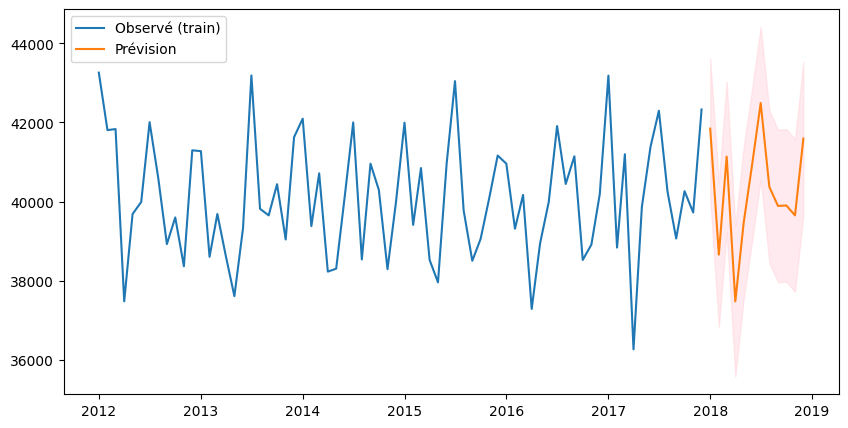

In [51]:
y_pred_sarima = results_sarima.get_forecast(steps=12)
pred_mean = y_pred_sarima.predicted_mean
conf_int = y_pred_sarima.conf_int()

plt.figure(figsize=(10,5))
plt.plot(y_train, label='Observé (train)')
plt.plot(pred_mean, label='Prévision')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

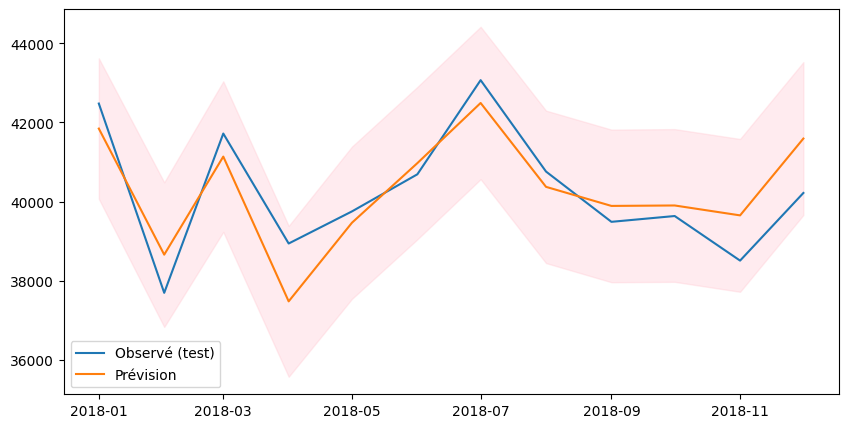

In [52]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Observé (test)')
plt.plot(pred_mean, label='Prévision')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

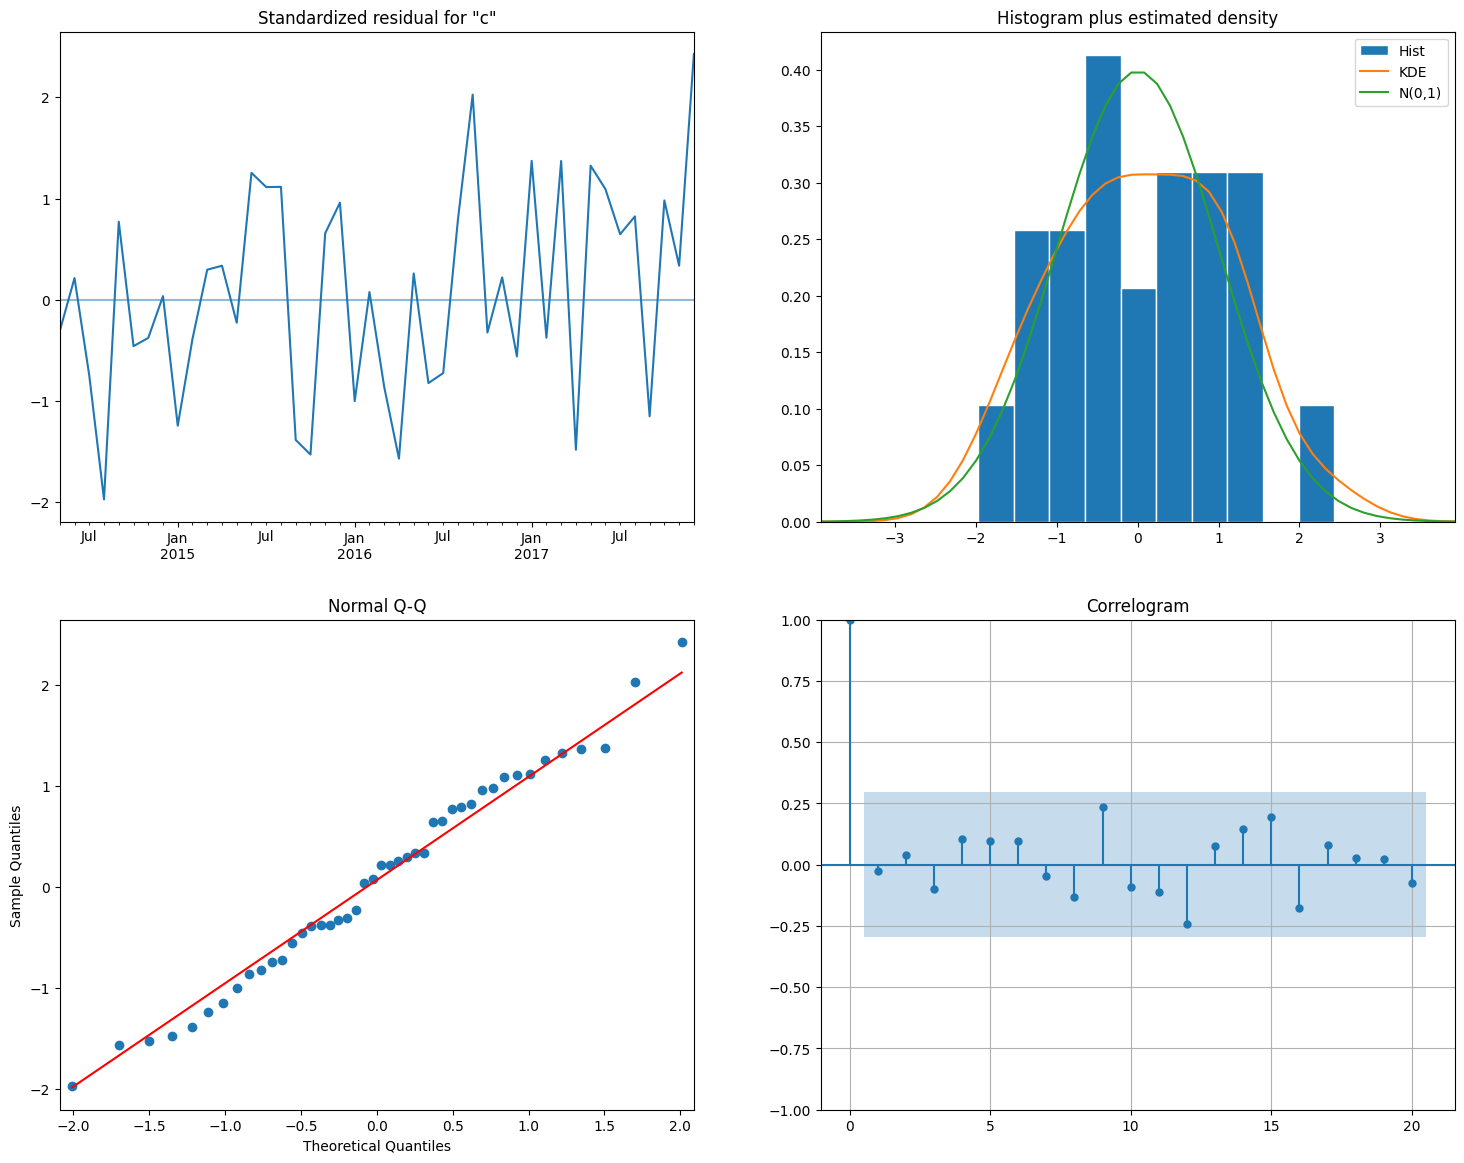

In [53]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))


plot_diagnostics(sarima_res = results_sarima, figsize=(18,14), lags=20)
plt.grid(True)

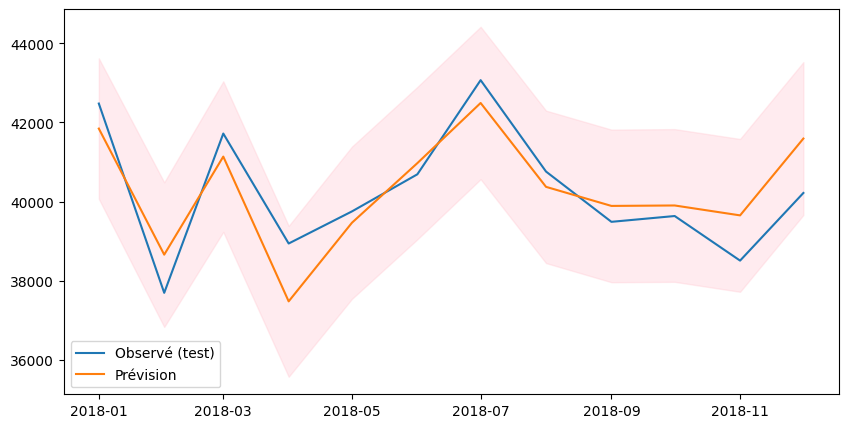

In [54]:
forecast = results_sarima.get_forecast(steps=12)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Observé (test)')
plt.plot(pred_mean, label='Prévision')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

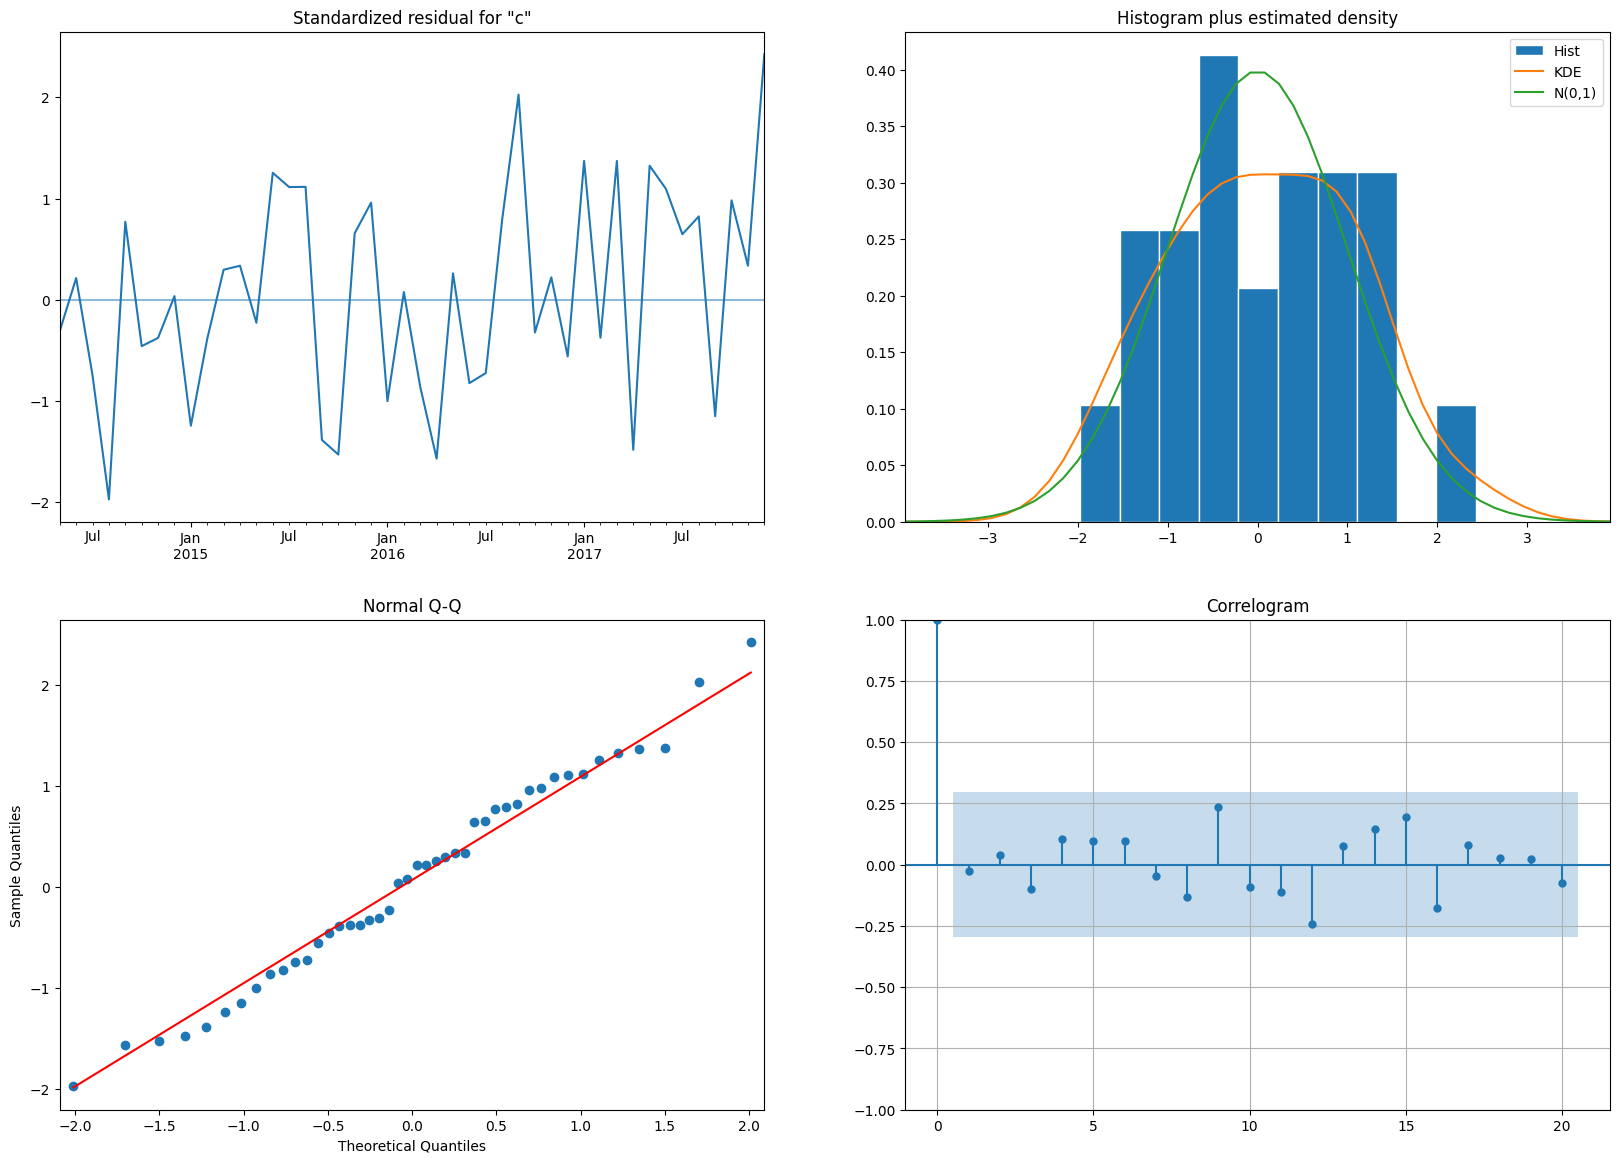

In [55]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))


plot_diagnostics(sarima_res =results_sarima, figsize=(20,14), lags=20)
plt.grid(True)


In [56]:

# Prévisions : 12 dernières valeurs
y_hw = np.array(y_pred_hw[-12:])                 # Holt-Winters
y_sarima = np.array(y_pred_sarima.predicted_mean[-12:])  # SARIMA

# Vraies valeurs du test
y_true = np.array(y_test)

# Fonction pour calculer les métriques
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return [mae, mse, rmse, mape, r2]

# Calcul des métriques
metrics_hw = calculate_metrics(y_true, y_hw)
metrics_sarima = calculate_metrics(y_true, y_sarima)

# Créer le tableau comparatif
metrics_names = ['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'R²']
comparison_df = pd.DataFrame({
    'Métrique': metrics_names,
    'Holt-Winters': metrics_hw,
    'SARIMA': metrics_sarima
})

# Afficher le tableau
print(comparison_df)


   Métrique   Holt-Winters         SARIMA
0       MAE     757.393420     697.078193
1       MSE  799510.982267  657467.458066
2      RMSE     894.153780     810.843671
3  MAPE (%)       1.901761       1.749265
4        R²       0.657812       0.718606


# 📊 Étapes de mise en œuvre d’un modèle SARIMAX

## 1. Analyse exploratoire
- Visualiser la série pour détecter **tendance, saisonnalité, volatilité**.  
- Calculer les **fonctions d’autocorrélation (ACF)** et **autocorrélation partielle (PACF)** pour identifier les ordres potentiels *(p, q)*.  
- Vérifier la **stationnarité** de la série avec des tests statistiques comme **ADF** ou **KPSS**.  

## 2. Déterminer les paramètres
- Choisir les paramètres **(p, d, q)** pour la partie ARIMA.  
- Déterminer les paramètres saisonniers **(P, D, Q, s)** pour capturer les effets périodiques.  
- Inclure les **variables exogènes** (si disponibles) afin d’améliorer les prévisions.  

## 3. Estimer le modèle SARIMAX
- Ajuster le modèle en utilisant les paramètres choisis.  
- Vérifier la **convergence** de l’algorithme d’optimisation pour s’assurer que le modèle a bien été estimé.  

## 4. Évaluer le modèle
- Analyser les **résidus** (autocorrélation, normalité).  
- Calculer les métriques d’erreur : **MAE**, **RMSE**, et les critères d’information (**AIC**, **BIC**).  
- Ajuster les paramètres si nécessaire (approche itérative).  

## 5. Produire les prévisions
- Générer des **prévisions** sur la période cible.  
- Visualiser les **prédictions** et leurs **intervalles de confiance**.  

## 6. Valider et interpréter
- Comparer les prévisions avec les **valeurs réelles** sur un jeu de test.  
- Interpréter l’**impact des variables exogènes** sur les prévisions.  

## 7 Déployer et automatiser
- Mettre le modèle en **production** dans un pipeline de prévision.  
- Surveiller les **performances** et **réentraîner** régulièrement si nécessaire.  


In [57]:
df_consomation_fr=pd.read_csv("consomation_fr.csv")

In [58]:
df_consomation_fr=df_consomation_fr.drop(columns=["Territoire","Consommation totale"])
df_consomation_fr.head(2)

,Mois,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies
0,2012-01-01,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514
1,2012-02-01,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454


In [59]:
df_consomation_fr.set_index("Mois" , inplace = True)
df_consomation_fr.index=pd.to_datetime(df_consomation_fr.index)

In [61]:
df_consomation_fr.head(2)

,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies
Mois,,,,,,,,,,
2012-01-01,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514
2012-02-01,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454


In [62]:
df2 = pd.merge(df, df_consomation_fr, how='inner', on='Mois')
df2

,dju_chauffage,conso_corr,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies
Mois,,,,,,,,,,,,
2012-01-01,336.0,43259.231509,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514
2012-02-01,435.9,41804.889062,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454
2012-03-01,201.9,41831.997497,48583,37549.0,5276,1435.0,666,3175,3894,977,356,531
2012-04-01,230.3,37474.827072,44192,33100.0,3484,1655.0,486,1343,5302,1572,329,405
2012-05-01,83.3,39684.138781,40433,29058.0,1772,854.0,368,549,7706,974,454,469
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,3.3,40757.492092,37283,27294.0,2515,502.0,189,1824,3906,1405,1349,811
2018-09-01,34.3,39486.242684,38868,30099.0,2144,348.0,157,1638,3028,1614,1194,787
2018-10-01,122.4,39633.104850,42356,31613.0,3721,793.0,152,2775,2931,2497,822,769


In [64]:
# Variables cibles et exogènes
y2 = df2['conso_corr']
X = df2[[ 'dju_chauffage','Production totale', 'Production nucléaire',
       'Production thermique totale', 'Production thermique charbon',
       'Production thermique fioul', 'Production thermique gaz',
       'Production hydraulique', 'Production éolien', 'Production solaire',
       'Production bioénergies']]  # exogène(s) sous forme DataFrame

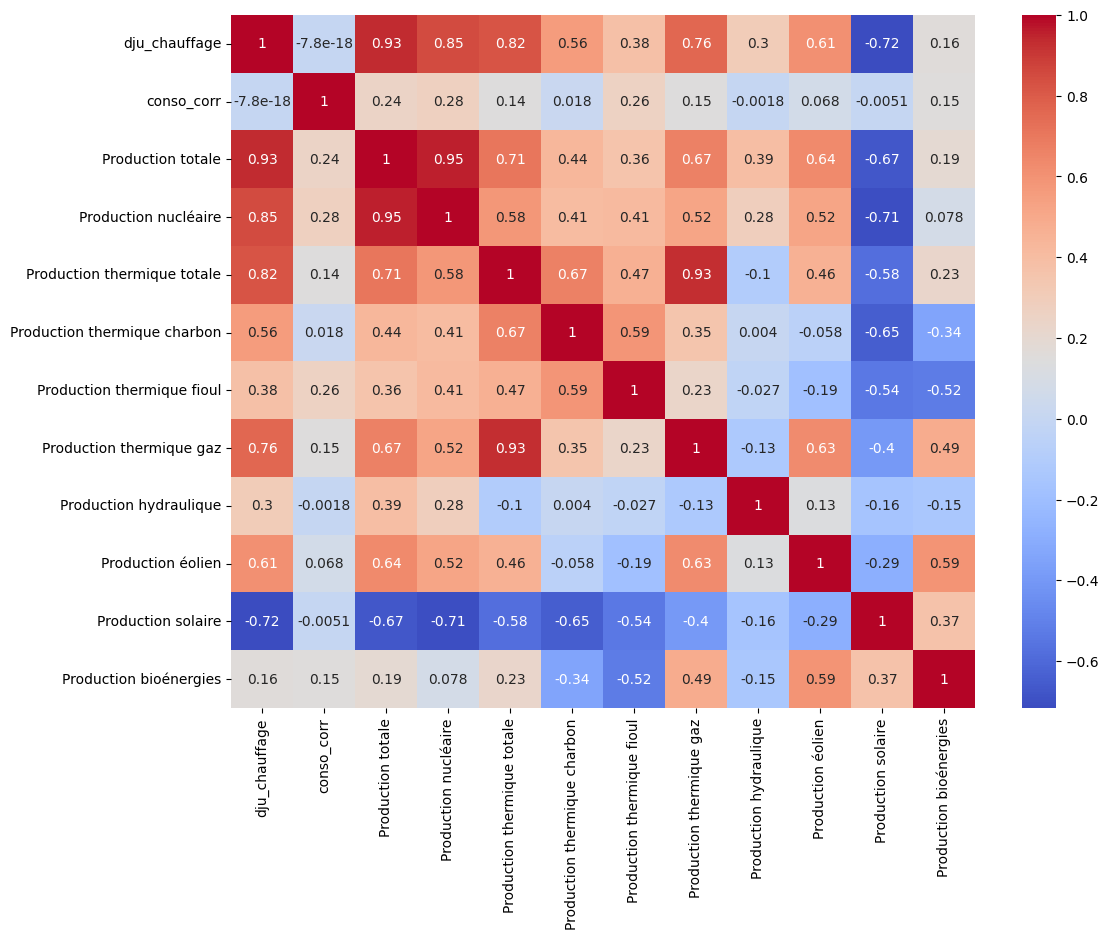

In [67]:
#### Tester l'indépendance entre les variables
# Visualiser la corrélation
plt.figure(figsize=(12, 9))
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

D'après l'analyse de la matrice de corrélation (représentée par carte de chaleurs), les variables **Production totale, Production nucléaire, Production thermique totale et Production thermique gaz** ont été éliminées en raison de leurs fortes corrélations avec d'autres variables, afin d'éviter les problèmes de multicolinéarité dans l'analyse en composantes principales (ACP).



In [69]:
df2.columns

Index(['dju_chauffage', 'conso_corr', 'Production totale',
       'Production nucléaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production éolien', 'Production solaire', 'Production bioénergies'],
      dtype='object')

In [71]:
train_size = int(len(df2) * 0.8)

X_selected = df2[['dju_chauffage',
                  'Production thermique fioul',
                  'Production bioénergies',
                  'Production hydraulique',
                  'Production thermique charbon',
                  'Production solaire',
                  'Production éolien'
                 ]]

X_selected_train2, X_selected_test2 = X_selected.iloc[:train_size], X_selected.iloc[train_size:]
y_train2, y_test2 = y2.iloc[:train_size], y2.iloc[train_size:]

In [72]:
print("Train y:", y_train2.shape)
print("Test y :", y_test2.shape)

print("Train x:", X_selected_train2.shape)
print("Test  x:", X_selected_test2.shape)

Train y: (67,)
Test y : (17,)
Train x: (67, 7)
Test  x: (17, 7)


In [74]:


p_values = [0,1]
d_values = [1]
q_values = [0,1]
P_values = [0,1]
D_values = [1]
Q_values = [0,1]
s = 12

best_aic = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

for p,d,q in itertools.product(p_values,d_values,q_values):
    for P,D,Q in itertools.product(P_values,D_values,Q_values):
        try:
            model = sm.tsa.statespace.SARIMAX(y2, exog=X_selected,
                                              order=(p,d,q),
                                              seasonal_order=(P,D,Q,s),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
                best_seasonal_order = (P,D,Q,s)
                best_model = res
        except:
            continue

print("Meilleur modèle :")
print("Order:", best_order)
print("Seasonal Order:", best_seasonal_order)
print("AIC:", best_aic)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Meilleur modèle :
Order: (0, 1, 1)
Seasonal Order: (0, 1, 1, 12)
AIC: 947.4007033007406


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
model_sarimax = sm.tsa.SARIMAX(
    y_train2,
    exog=X_selected_train2,  # None si pas de variable externe
    order=(0,1,1),          # p,d,q
    seasonal_order=(0,1,1,12)  # P,D,Q,s
)

results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         conso_corr   No. Observations:                   67
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -447.847
Date:                            Tue, 16 Sep 2025   AIC                            915.694
Time:                                    16:57:32   BIC                            935.583
Sample:                                01-01-2012   HQIC                           923.364
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
dju_chauffage                  -19.7385      3.621     -5.451      0.000     -

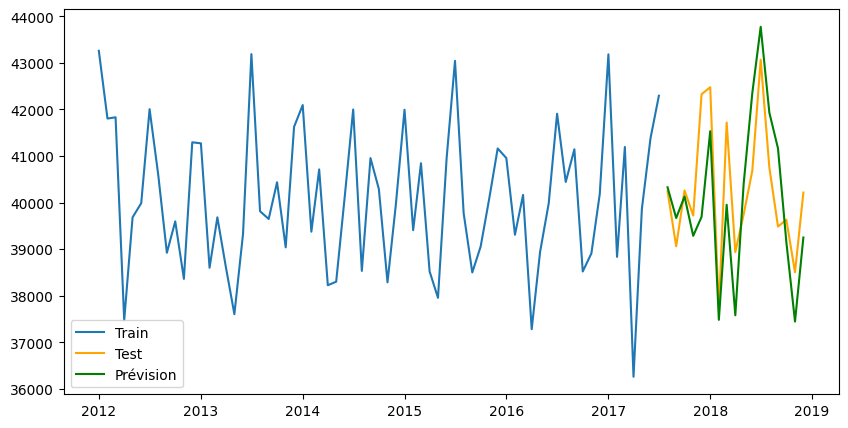

In [76]:
# Prédiction
y_pred_sarimax = results_sarimax.predict(
    start=len(y_train2),
    end=len(y_train2) + len(y_test2) - 1,
    exog=X_selected_test2
)

# Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_train2, label="Train")
plt.plot(y_test2, label="Test", color="orange")
plt.plot(y_pred_sarimax , label="Prévision", color="green")
plt.legend()
plt.show()

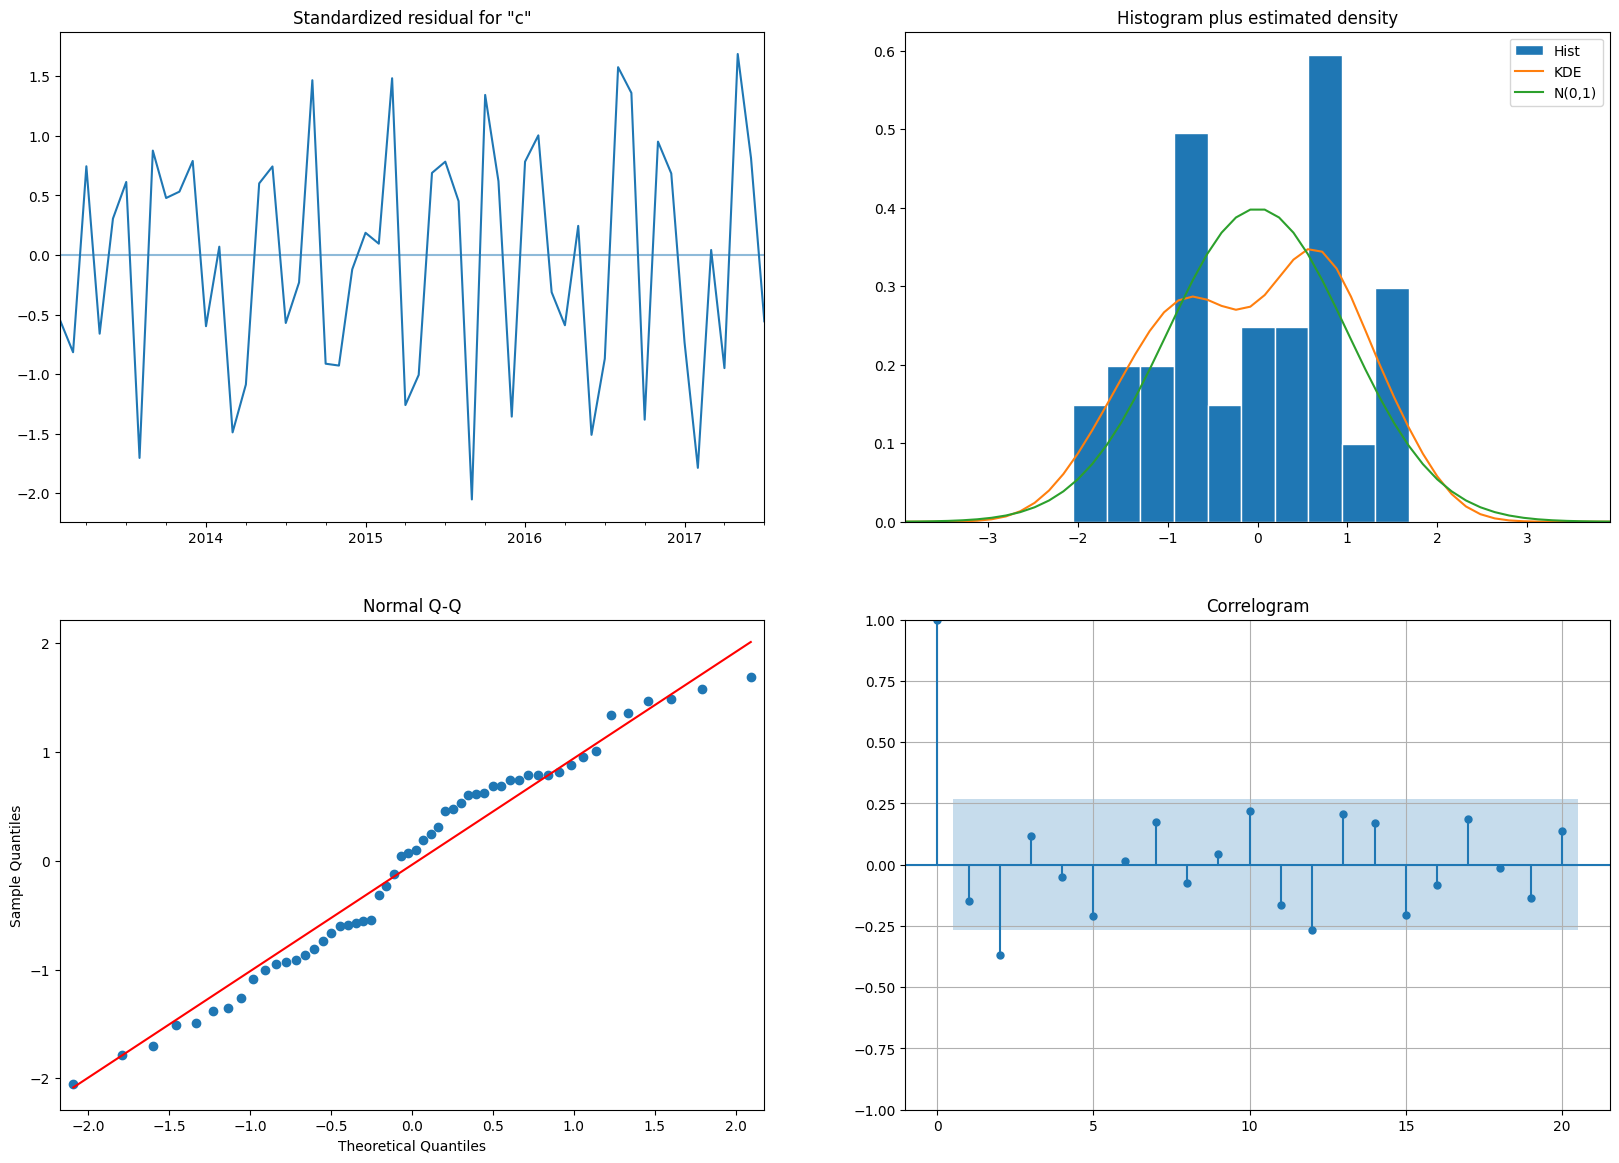

In [77]:
plot_diagnostics(sarima_res = results_sarimax, figsize=(20,14), lags=20)
plt.grid(True)

In [78]:
# S'assurer que y_test2 et y_pred_sarimax ont la même longueur
y_true = y_test2
y_pred = y_pred_sarimax

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAPE (%)
mask = y_true != 0  # éviter division par zéro
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# R²
r2 = r2_score(y_true, y_pred)

# Affichage
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE (%): {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 973.55
MSE: 1387929.82
RMSE: 1178.10
MAPE (%): 2.40%
R²: 0.3067


# 📊 Conclusion : Comparaison des modèles Holt-Winters et SARIMA

L'analyse des métriques de performance met en évidence que le modèle **SARIMA** surpasse le modèle **Holt-Winters** pour cette série temporelle :

- **MAE** et **RMSE** plus faibles → prévisions plus proches des valeurs réelles.  
- **MSE** significativement réduit → meilleure capture de la dynamique des données et réduction des erreurs importantes.  
- **MAPE** plus bas → précision relative améliorée (erreurs en pourcentage plus faibles).  
- **R²** plus élevé → SARIMA explique une part plus importante de la variance de la série, donc un meilleur ajustement global.  

✅ **Conclusion** : Le modèle **SARIMA** est plus performant et fournit des prévisions plus précises et fiables.  
Il est donc recommandé pour la mise en production et pour appuyer la prise de décision sur cette série temporelle.
